In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [3]:
from util import rmse

Using TensorFlow backend.


In [4]:
%ls '../output'

CNN_pred.csv  FM_pred.csv  LR_pred.csv  MLP_pred.csv  RNN_pred.csv


In [5]:
train = pd.read_table('../input/train.tsv')
train['log1p_price'] = np.log1p(train['price'])
log1p_price = train.set_index('train_id')['log1p_price']

In [6]:
pred_files = ['MLP_pred.csv', 'CNN_pred.csv', 'RNN_pred.csv', 'FM_pred.csv',  'LR_pred.csv']

In [7]:
mlp_df = pd.read_csv('../output/MLP_pred.csv', index_col='train_id')
cnn_df = pd.read_csv('../output/CNN_pred.csv', index_col='train_id')
rnn_df = pd.read_csv('../output/RNN_pred.csv', index_col='train_id')
lr_df = pd.read_csv('../output/LR_pred.csv', index_col='train_id')
fm_df = pd.read_csv('../output/FM_pred.csv', index_col='train_id')

## score

In [8]:
def rmse_func(pred):
    return rmse(pred, log1p_price.loc[pred.index])

In [9]:
print('MLP: ' + ' '.join('{:.5f}'.format(score) for score in sorted(mlp_df.agg(rmse_func))))
print('CNN: ' + ' '.join('{:.5f}'.format(score) for score in sorted(cnn_df.agg(rmse_func))))
print('RNN: ' + ' '.join('{:.5f}'.format(score) for score in sorted(rnn_df.agg(rmse_func))))
print('LR : ' + ' '.join('{:.5f}'.format(score) for score in sorted(lr_df.agg(rmse_func))))
print('FM : ' + ' '.join('{:.5f}'.format(score) for score in sorted(fm_df.agg(rmse_func))))

MLP: 0.41497 0.41521 0.41587 0.41606 0.41683 0.41700 0.41767 0.41946
CNN: 0.41314 0.41409 0.41467 0.41469 0.41500 0.41530 0.41535 0.41877
RNN: 0.41182 0.41231 0.41389 0.41497 0.41544 0.41681 0.41782 0.41885
LR : 0.43637 0.43637 0.43637 0.43637 0.43637 0.43637 0.43637 0.43637
FM : 0.42138 0.42140 0.42179 0.42200 0.42200 0.42204 0.42222 0.42251


In [10]:
score_df = pd.concat(
    [
        pd.DataFrame({'model': 'MLP', 'score': mlp_df.agg(rmse_func).values}),
        pd.DataFrame({'model': 'CNN', 'score': cnn_df.agg(rmse_func).values}),
        pd.DataFrame({'model': 'RNN', 'score': rnn_df.agg(rmse_func).values}),
        pd.DataFrame({'model': 'LR', 'score': lr_df.agg(rmse_func).values}),
        pd.DataFrame({'model': 'FM', 'score': fm_df.agg(rmse_func).values}),
    ],
    ignore_index=True
)

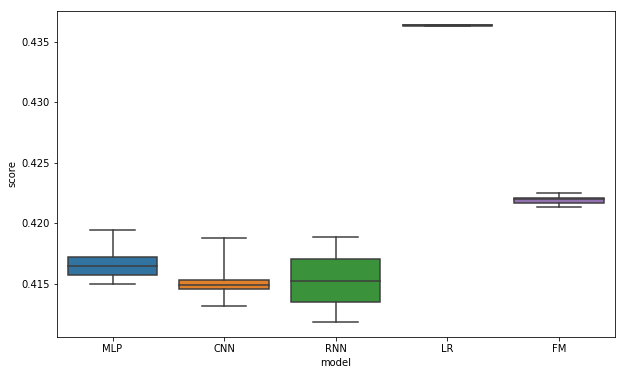

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='score', data=score_df, whis=1e9)

## average score

In [12]:
print('MLP: {:.5f}'.format(mlp_df.agg(rmse_func).mean()))
print('CNN: {:.5f}'.format(cnn_df.agg(rmse_func).mean()))
print('RNN: {:.5f}'.format(rnn_df.agg(rmse_func).mean()))
print('LR : {:.5f}'.format(lr_df.agg(rmse_func).mean()))
print('FM : {:.5f}'.format(fm_df.agg(rmse_func).mean()))

MLP: 0.41663
CNN: 0.41513
RNN: 0.41524
LR : 0.43637
FM : 0.42192


## Ensemble / averaging of single type models

In [13]:
average_mlp = mlp_df.mean(axis=1)
average_cnn = cnn_df.mean(axis=1)
average_rnn = rnn_df.mean(axis=1)
average_lr = lr_df.mean(axis=1)
average_fm = fm_df.mean(axis=1)

In [14]:
print('MLP: {:.5f}'.format(average_mlp.agg(rmse_func).mean()))
print('CNN: {:.5f}'.format(average_cnn.agg(rmse_func).mean()))
print('RNN: {:.5f}'.format(average_rnn.agg(rmse_func).mean()))
print('LR : {:.5f}'.format(average_lr.agg(rmse_func).mean()))
print('FM : {:.5f}'.format(average_fm.agg(rmse_func).mean()))

MLP: 0.38990
CNN: 0.39384
RNN: 0.39909
LR : 0.43637
FM : 0.42012


## Ensemble / weighted averaging of multiple type models

There is a risk of overfitting here because test dataset is used for weight fitting.

You should use independent test dataset for validation.

In [15]:
def optimize_weighted_averaging_loss(preds):
    ensemble_lr = LinearRegression(fit_intercept=False)
    ensemble_X = pd.concat(preds, axis=1)
    ensemble_lr.fit(ensemble_X, log1p_price.loc[ensemble_X.index])
#     print('weights:', ensemble_lr.coef_)
    return rmse(ensemble_lr.predict(ensemble_X), log1p_price.loc[ensemble_X.index])

In [16]:
from itertools import combinations

In [17]:
averaging_preds_by_model = {
    'MLP': average_mlp,
    'CNN': average_cnn,
    'RNN': average_rnn,
    'LR': average_lr,
    'FM': average_fm
}

In [18]:
modelss = []
weighted_averaging_scores = []
for num_models in range(1, 5 + 1):
    for models in combinations(averaging_preds_by_model.keys(), num_models):
        modelss.append(', '.join(models))

        preds = [averaging_preds_by_model[model] for model in models]
        weighted_averaging_scores.append(optimize_weighted_averaging_loss(preds))

weighted_averaging_score_df = pd.DataFrame({'models': modelss, 'score': weighted_averaging_scores})

In [19]:
weighted_averaging_score_df.sort_values('score')

,models,score
30,"MLP, CNN, RNN, LR, FM",0.377730
25,"MLP, CNN, RNN, LR",0.378288
27,"MLP, CNN, LR, FM",0.378713
26,"MLP, CNN, RNN, FM",0.378872
15,"MLP, CNN, RNN",0.378909
28,"MLP, RNN, LR, FM",0.379212
16,"MLP, CNN, LR",0.379302
17,"MLP, CNN, FM",0.379769
5,"MLP, CNN",0.379827
18,"MLP, RNN, LR",0.379839
